In [ ]:
# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための最終段階のコード
# （変更前）実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
# （変更後）実行環境（カーネル）はTSTVIDEO_Prog（Python 3.12.11）で行ってください
#
# ■メモ
# 改善確が終わったら、バージョンアップする。
# 仮想環境で別のVScodeで同じ環境に接続してるとつながらない？
#
# v0.0.4での対応→10/24移行こちらを再開
# フレームの取りこぼしがあるため改善する。取りこぼしというか同じフレームを複数回処理してる。→継続(60fpsでカメラスレッドで読み込んで、30fpsでキャプチャ)
# 10分毎の画像消去（18000）あたりでキュー詰まりを起こしてる。カクツキ検知、保存ともに。→継続
# プレビュー画面を触るとキャプチャが止まってそう。。。→継続
# ベンチマークテストプログラムの内容を反映させること。→一応反映済みだが、変数や処理の整合性の再確認が必要。またベンチマークテストをもう一回見直して反映漏れがないか確認が必要。
# 今出ているエラーの修正をすること。（なんかlogフォルダが見つからないらしい。）coplilotかChatGPTをつかうこと
# ===============================================

In [2]:
# ===========================================================================
# 必要なライブラリのインポート（重複除去・カテゴリ別整理）
# ===========================================================================

# --- 画像処理・数値計算 ---
import cv2                   # OpenCV: 画像・動画の読み込みと処理
import numpy as np           # NumPy: 配列操作・数値計算
import cupy as cp            # CuPy: GPU対応のNumPy互換ライブラリ

# --- 可視化 ---
import matplotlib.pyplot as plt          # グラフ描画
import matplotlib.font_manager as fm     # フォント管理（日本語対応など）

# --- GUI ---
import tkinter as tk         # GUI作成（基本ウィジェット）
from tkinter import ttk      # GUI作成（拡張ウィジェット）

# --- ファイル・システム操作 ---
import os                    # ファイルパス・環境操作
import shutil                # ファイルコピー・削除
import csv                   # CSVファイルの読み書き
import tempfile              # 一時ファイルの作成・管理
import sys                   # システム関連（終了処理・パス操作など）

# --- 並行処理 ---
import threading             # マルチスレッド処理
import queue                 # スレッド間通信・キュー処理（Queue, LifoQueue, PriorityQueue など）
from queue import Queue      # スレッド間通信・キュー処理

# --- その他ユーティリティ ---
import time                  # 待機・時間計測
from datetime import datetime  # 日付・時刻操作
import gc                    # メモリ管理（ガーベジコレクション）
import re                    # 正規表現処理

# --- システム情報 ---
import platform              # OS情報取得
import psutil                # CPU・メモリなどのシステム情報取得
import GPUtil                # GPU情報取得
# --- データ処理 ---
import pandas as pd          # 表形式データの処理（CSVなど）

# Windows用
try:
    import win32com.client
    from win32com.client import GetObject
except ImportError:
    win32com = None

# Try import cupy; if unavailable or no GPU, fall back to numpy mode
USE_CUPY = False
try:
    import cupy as cp
    try:
        gpu_count = cp.cuda.runtime.getDeviceCount()
        if gpu_count > 0:
            USE_CUPY = True
        else:
            USE_CUPY = False
    except Exception:
        USE_CUPY = False
except Exception:
    USE_CUPY = False

In [3]:
# ===========================================================================
# 日本語フォント設定
# ===========================================================================
# 日本語を含むタイトル・ラベル・注釈を正しく表示するために、
# 既定フォントを「MS ゴシック（MS Gothic）」に変更します（主に Windows 環境向け）
plt.rcParams['font.family'] = 'MS Gothic'

# 軸や目盛りラベルの負号について、Unicode のマイナス記号（U+2212）ではなく
# ASCII のハイフン（-）を使うようにします。
# 一部の日本語フォントで U+2212 のグリフが無い／崩れるケースを避けるための対策です。
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# ===========================================================================
# 一時フォルダとCuPy環境の安全設定
# ===========================================================================
# すべての環境でASCIIパスを使う
# - 非 ASCII（日本語やスペース、絵文字など）が混ざると、NVRTC や一部のツールチェーンで失敗することがあるため、示的に ASCII の短いパスを指定（例: C:\cupy_temp）
SAFE_TEMP_DIR = r"C:\cupy_temp"
os.makedirs(SAFE_TEMP_DIR, exist_ok=True)

# Windowsの環境変数を一時的に上書き
# Python や一部のネイティブツールは TMP/TEMP を参照するため、ここで ASCII パスへ誘導
# tempfile.tempdir も直接上書きすることで、tempfile.* API の出力先を合わせる
os.environ["TMP"] = SAFE_TEMP_DIR
os.environ["TEMP"] = SAFE_TEMP_DIR
tempfile.tempdir = SAFE_TEMP_DIR

# CuPyのキャッシュ・インクルードディレクトリを安全パスに設定
# CUPY_CACHE_DIR: RawKernel/RawModule の JIT コンパイル成果物（PTX/CUBIN 等）の保存先
# CUPY_INCLUDE_DIR: 本スクリプト内で使う独自の「インクルード配置先」
# ※ CuPy 標準の環境変数名ではない（後述の注意参照）
CUPY_CACHE_DIR = os.path.join(SAFE_TEMP_DIR, "cupy_cache")
CUPY_INCLUDE_DIR = os.path.join(SAFE_TEMP_DIR, "cupy_include")
os.makedirs(CUPY_CACHE_DIR, exist_ok=True)
os.makedirs(CUPY_INCLUDE_DIR, exist_ok=True)

# CuPy にキャッシュ先を伝える公式の環境変数
os.environ["CUPY_CACHE_DIR"] = CUPY_CACHE_DIR
# これは「アプリ側で参照するためのマーカー」として設定（CuPy が自動で読む標準名ではない）
os.environ["CUPY_INCLUDE_PATH"] = CUPY_INCLUDE_DIR

print(f"✅ CuPy cache dir set to: {CUPY_CACHE_DIR}")
print(f"✅ CuPy include dir set to: {CUPY_INCLUDE_DIR}")

# CuPy includeをコピー（ビルド済みexe配下 or site-packagesから）
# PyInstaller での配布を想定：sys._MEIPASS が存在すれば、展開先配下を優先的に探す
# 開発時（通常の Python 実行）では site-packages 配下を探す
try:
    # PyInstaller でビルドされた実行ファイルかどうかを判定するための条件
    if hasattr(sys, "_MEIPASS"):
        # PyInstaller 実行時にリソースが展開される一時ディレクトリ
        base_dir = sys._MEIPASS
    else:
        # スクリプト自身のディレクトリ
        base_dir = os.path.dirname(os.path.abspath(__file__))

    possible_paths = [
        # ビルド済み exe にヘッダーを同梱した場合
        os.path.join(base_dir, "cupy", "_core", "include", "cupy"),
        # 通常の site-packages 配下（仮想環境も含む）
        os.path.join(sys.prefix, "Lib", "site-packages", "cupy", "_core", "include", "cupy")
    ]
    for p in possible_paths:
        if os.path.exists(p):
            # 既存があれば一旦削除して差し替え（バージョン差異による不整合を防止）
            dst = os.path.join(CUPY_INCLUDE_DIR, "cupy")
            if os.path.exists(dst):
                shutil.rmtree(dst)
            shutil.copytree(p, dst)
            print(f"✅ Copied CuPy headers from: {p}")
            break
    else:
        # ヘッダーが見つからない場合でも、RawKernel で include を使わなければ致命的ではない
        print("⚠ CuPy header files not found, proceeding without copy")

except Exception as e:
    # 権限、ロック、AV によるブロックなどで失敗することがある
    print(f"⚠ Failed to copy CuPy headers: {e}")

✅ CuPy cache dir set to: C:\cupy_temp\cupy_cache
✅ CuPy include dir set to: C:\cupy_temp\cupy_include
⚠ Failed to copy CuPy headers: name '__file__' is not defined


In [5]:
# ===========================================================================
# 出力フォルダの作成（デスクトップを避ける）
# ===========================================================================
# ベース出力フォルダ
# os.getcwd() は「現在の作業ディレクトリ（実行開始時のカレント）」を返します。
safe_output_base = os.path.join(os.getcwd(), "CameraCapture_GPU_Output")
# 既存でも例外にしない
os.makedirs(safe_output_base, exist_ok=True)
# タイムスタンプ（フォルダ名用）
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# 実際に保存するセッション用サブフォルダ
save_folder = os.path.join(safe_output_base, timestamp)
os.makedirs(save_folder, exist_ok=True)
# CSV の保存パス：
csv_path = os.path.join(save_folder, "camera_frame_test.csv")
# パス確認用のログ出力
print(f"📁 Output folder: {save_folder}")

📁 Output folder: c:\Users\HP_PC\github\MAIN_workspace_TestProg_video\video-stutter-detector\notebooks\CameraCapture_GPU_Output\2025-10-24_17-12-25


In [6]:
# ===========================================================================
# 利用可能ビデオキャプチャデバイス一覧取得関数
# ===========================================================================
def get_camera_name_from_index(idx):
    # WMI（Windows Management Instrumentation）が使えない環境では汎用名を返す
    if win32com is None:
        return f"Camera {idx}"

    try:
        # WMI に接続（"winmgmts:" は WMI のルート名前空間
        wmi = GetObject("winmgmts:")
        # すべての PnP（プラグアンドプレイ）デバイスの情報を取得
        devices = wmi.InstancesOf("Win32_PnPEntity")
        # 「名前に Camera / Webcam / USB を含むもの」を見つけたらその名前を返す
        # ※ 最初の一致を返すため、複数カメラがあっても idx ごとに同じ名前になる可能性がある
        for dev in devices:
            if dev.Name and ("Camera" in dev.Name or "Webcam" in dev.Name or "USB" in dev.Name):
                return dev.Name
    except Exception:
        # WMI 処理に失敗した場合は汎用名にフォールバック
        pass

    # 一致なし・例外時
    return f"Camera {idx}"

# --- 接続されているビデオキャプチャデバイス（Webカメラなど）を検出して一覧にする処理 ---
def list_video_devices(max_devices=10, timeout=1.0):
    # 使用可能なビデオデバイスの一覧を格納するリスト
    devices = []

    # 指定されたインデックスのデバイスが使用可能か確認する関数
    def try_open_device(idx, result_dict):
        try:
            # Windows環境でDirectShowを使ってデバイスを開く
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)
            if cap.isOpened():
                # デバイスが正常に開けた場合、結果を記録
                result_dict["opened"] = True
            cap.release()
        except Exception as e:
            # 例外が発生した場合は無視してログ出力
            print(f"デバイス {idx} は無視されました: {e}")
            result_dict["opened"] = False

    # 指定された最大数までデバイスインデックスを順に確認
    for idx in range(max_devices):
        result = {"opened": False}
        # スレッドを使ってデバイス確認を非同期で実行
        t = threading.Thread(target=try_open_device, args=(idx, result))
        t.start()
        # 指定されたタイムアウト時間で待機
        t.join(timeout=timeout)

        if t.is_alive():
            # タイムアウトした場合はスキップ
            print(f"デバイス {idx} はタイムアウト ({timeout} 秒) によりスキップされました")
        elif result["opened"]:
            # デバイスが開けた場合は名前を取得してリストに追加
            name = get_camera_name_from_index(idx)
            devices.append((idx, name))

    # 使用可能なデバイスの一覧を返す
    return devices

# このファイルが直接実行されたときだけ実行される処理
if __name__ == "__main__":
    # このスクリプトが直接実行された場合にのみ以下の処理を実行する
    print("利用可能なビデオキャプチャデバイス:")
    # 最大10個のデバイスを対象に、1秒のタイムアウトで使用可能なカメラを検出
    devices = list_video_devices(max_devices=10, timeout=1.0)
    # 検出された各デバイスのインデックスと名前を表示
    for idx, name in devices:
        print(f"デバイス番号: {idx}, 名前: {name}")

利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: NVIDIA USB Type-C Port Policy Controller
デバイス番号: 1, 名前: NVIDIA USB Type-C Port Policy Controller


In [7]:
# ===========================================================================
# GUI関数
# ===========================================================================
def launch_gui(devices):
    # カメラデバイス番号※辞書で選択結果を共有（クロージャ内で参照できるようにする）
    selected_device = {"idx": None} 
    # カメラスレッド設定FPS
    cam_thread_fps = 30
    # カメラキャプチャ設定FPS
    capture_fps = 15
    # 撮影時間（秒）
    capture_time = 120
    frame_interval = 1.0 / capture_fps
    # 撮影時間 × FPS
    limit_frames = capture_time * capture_fps  

    def apply_settings():
        # グローバル変数を関数内で更新するために宣言※selected_device は辞書の中身を更新するだけなので global 不要
        global cam_thread_fps, capture_fps, capture_time, frame_interval, limit_frames
        # コンボボックスで選択されたデバイスのインデックスを取得して保存
        selected_device["idx"] = devices[combo.current()][0]
        # カメラスレッドのFPS
        cam_thread_fps = int(cam_thread_fps_slider.get())
        # カメラキャプチャのFPS
        capture_fps = int(capture_fps_slider.get())
        # 撮影時間（秒）
        capture_time = int(capture_time_slider.get())
        # 1フレームあたりの間隔（秒）を計算
        frame_interval = 1.0 / capture_fps
        # 撮影する総フレーム数を計算（FPS × 時間）
        limit_frames = capture_time * capture_fps
        # 設定内容をコンソールに表示（確認用）
        print(f"✅ 設定反映: カメラスレッド設定FPS={cam_thread_fps},　カメラキャプチャ設定FPS={capture_fps},　撮影時間={capture_time}秒, limit_frames={limit_frames}")
        # GUIウィンドウを閉じる（設定完了後）
        root.destroy()

    # メインウィンドウ作成
    root = tk.Tk()
    # ウィンドウタイトル設定
    root.title("条件設定")
    # サイズ変更を禁止
    root.resizable(False, False)

    # デバイス番号の選択
    tk.Label(root, text="使用するデバイスを選択:").grid(row=0, column=0, pady=5, sticky="w")
    display_names = [f"{name} (番号: {idx})" for idx, name in devices]
    device_var = tk.StringVar()
    combo = ttk.Combobox(root, textvariable=device_var, values=display_names, state="readonly")
    combo.current(0)
    combo.grid(row=0, column=1, pady=5)

    # カメラスレッドFPS
    tk.Label(root, text="カメラスレッド設定FPS").grid(row=1, column=0)
    cam_thread_fps_slider = tk.Scale(root, from_=1, to=60, orient=tk.HORIZONTAL)
    cam_thread_fps_slider.set(cam_thread_fps)
    cam_thread_fps_slider.grid(row=1, column=1)

    # カメラキャプチャFPS
    tk.Label(root, text="カメラキャプチャ設定FPS").grid(row=2, column=0)
    capture_fps_slider = tk.Scale(root, from_=1, to=60, orient=tk.HORIZONTAL)
    capture_fps_slider.set(capture_fps)
    capture_fps_slider.grid(row=2, column=1)

    # --- 撮影時間（秒） ---
    tk.Label(root, text="撮影時間（秒）").grid(row=3, column=0)
    capture_time_slider = tk.Scale(root, from_=10, to=600, orient=tk.HORIZONTAL)
    capture_time_slider.set(capture_time)
    capture_time_slider.grid(row=3, column=1)

    # 開始ボタン
    tk.Button(root, text="開始", command=apply_settings).grid(row=4, column=0, columnspan=2, pady=10)

    # GUIを表示し、ユーザー操作を受け付ける
    root.mainloop()

    # 閉じた後、選択されたデバイス番号などを返す（デバイス番号は選択なしなら None）
    return {"idx": selected_device["idx"]}, cam_thread_fps, capture_fps, capture_time, frame_interval, limit_frames


In [8]:
# ===========================================================================
# 安全で完全なフォルダ削除関数※Windows対応・再試行付き
# ===========================================================================
def safe_rmtree(folder_path: str, retry=3, wait=0.5):
    # --- 存在チェック処理 ---
    if not os.path.exists(folder_path):
        print(f"🗑️ フォルダ不存在: {folder_path}")
        return

    # --- フォルダ内の全要素を取得処理※下位から上位へ削除するため ---
    def get_all_entries(path):
        entries = []

        # topdown=False により、ファイル → サブフォルダ → 親フォルダ の順に削除可能
        for root, dirs, files in os.walk(path, topdown=False):
            # ファイルを追加
            entries.extend([os.path.join(root, f) for f in files])
            # ディレクトリを追加
            entries.extend([os.path.join(root, d) for d in dirs])
        return entries

    # --- 削除処理※本体 ---
    for attempt in range(retry):
        try:
            # 削除対象の全ファイル・フォルダを取得
            all_entries = get_all_entries(folder_path)
            total = len(all_entries)

            # サブフォルダ・ファイルが空ならフォルダ自体を削除
            if total == 0:
                os.rmdir(folder_path)
                print(f"🗑️ 完全削除済み: {folder_path}")
                return

            # ---削除ループ処理※進捗付き ---
            for i, entry in enumerate(all_entries, start=1):
                try:
                    if os.path.isfile(entry) or os.path.islink(entry):
                        # ファイル or シンボリックリンク削除
                        os.remove(entry)
                    elif os.path.isdir(entry):
                        # 空フォルダ削除
                        os.rmdir(entry)
                except Exception as e:
                    print(f"⚠ 削除失敗: {entry} → {e}")

                # --- 進捗バー表示処理 ---
                pct = int(i / total * 100)
                bar_len = 30
                filled = int(bar_len * pct / 100)
                sys.stdout.write(f"\r削除中: [{'#'*filled}{'-'*(bar_len-filled)}] {pct}%")
                sys.stdout.flush()


            # --- 最後にフォルダ自体を削除処理 ---
            try:
                os.rmdir(folder_path)
            except Exception as e:
                print(f"\n⚠ フォルダ自体の削除失敗: {e}")
            else:
                print(f"\n🗑️ 完全削除済み: {folder_path}")
            # 成功したらループを抜ける
            break

        except Exception as e:
            print(f"\n⚠ 削除中エラー: {e} → {wait}秒後に再試行 ({attempt+1}/{retry})")
            time.sleep(wait)
    else:
        # retry 回すべて失敗した場合
        print(f"❌ {folder_path} の削除に失敗しました。")

In [9]:
# ===========================================================================
# 動的なしきい値を推定する統計的学習クラス
# ===========================================================================
class AdaptiveThresholdTrainer:
    # --- 初期化処理 ---
    def __init__(self, alpha_mean=0.05, alpha_std=0.05, base_k=2.0, use_gpu=False):
        # 平均値の更新率（指数移動平均の係数）
        self.alpha_mean = alpha_mean
        # 標準偏差の更新率（変動の追従速度）
        self.alpha_std = alpha_std
        # 基本のしきい値係数（kσルール）
        self.base_k = base_k
        # GPU（CuPy）を使用するかどうか
        self.use_gpu = use_gpu
        # クラス内の状態を初期化するためのメソッド呼び出し
        self.reset()

    # --- 平均・標準偏差・係数の初期化 ---
    def reset(self):
        # 平均値の初期化
        self.mean = None
        # 標準偏差の初期化
        self.std = None
        # 変動係数（安定度に応じて変化
        self.var_ratio = 1.0

    # --- 閾値の更新処理 ---
    def update(self, x):
        # 使用する配列ライブラリを選択
        xp = cp if self.use_gpu else np
        # x: 差分画素数 ※入力を float に変換（演算の安定性のため）
        x = float(x)

        # 初回は平均と標準偏差を初期化
        if self.mean is None:
            self.mean = x
            self.std = 0.0
        else:
            # 指数移動平均（EMA）で平均を更新
            prev_mean = self.mean
            self.mean = (1 - self.alpha_mean) * self.mean + self.alpha_mean * x
            # 平均の変化量から標準偏差を更新（EMAベース）
            diff = abs(x - prev_mean)
            
            if self.std is None:
            # 初回はそのまま代入
                self.std = diff
            else:
                self.std = (1 - self.alpha_std) * self.std + self.alpha_std * diff


        # 安定度に応じて係数を調整（変動が大きいときはしきい値を厳しく）
        # 変動係数（ゼロ除算防止）
        var = self.std / (self.mean + 1e-9)
        # 変動範囲制限
        self.var_ratio = max(0.5, min(2.0, 1.0 + (var - 0.1)))

        # 動的に調整された係数を使ってしきい値を計算
        dynamic_k = self.base_k * self.var_ratio
        # 負の値は許容しない
        threshold = max(self.mean - dynamic_k * self.std, 0.0)

        # threshold: 動きが少ないと判定するためのしきい値（float）
        return threshold

In [10]:
# ===========================================================================
# スレッドカメラクラス（常に最新フレームを保持）
# ===========================================================================
class CameraCapture:
    # --- カメラ初期化処理 ---
    #ここの値はデフォルト値（「引数を渡さなかったときの初期値」にすぎないため、メインループの引数を変えても影響しない）
    def __init__(
            self,
            device_number,
            width=640,
            height=480,
            cam_thread_fps=60
        ): 
        # カメラデバイスを指定して初期化（Windowsでは CAP_DSHOW を使うと安定）
        self.cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
        if not self.cap.isOpened():
            raise RuntimeError("❌ カメラを開けませんでした。")

        # --- カメラの基本設定 ---
        # 幅
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        # 高さ
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        # FPS（※注意：cam_thread_fps は外部変数）
        self.cap.set(cv2.CAP_PROP_FPS, cam_thread_fps)
        # バッファサイズ（1にすると遅延が減る）
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        # --- 自動補正をオフにする（安定した映像取得のため） ---
        # 自動露出OFF
        self.cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25)
        # 露出値（環境に応じて調整）
        self.cap.set(cv2.CAP_PROP_EXPOSURE, -6)
        # 自動ホワイトバランスOFF
        self.cap.set(cv2.CAP_PROP_AUTO_WB, 0)
        # ホワイトバランス設定
        self.cap.set(cv2.CAP_PROP_WHITE_BALANCE_BLUE_U, 4600)
        # ゲイン（ノイズ抑制）
        self.cap.set(cv2.CAP_PROP_GAIN, 0)

        # --- カメラが実際に設定できたFPS値を取得して保持 ---
        self.fps_set = self.cap.get(cv2.CAP_PROP_FPS)

        # --- 内部変数 ---
        # 最新フレーム
        self.frame = None
        # スレッド安全なアクセス用ロック
        self.lock = threading.Lock()
        # スレッド制御フラグ
        self.running = True

        # --- フレーム更新スレッドの起動 ---
        self.thread = threading.Thread(target=self._update, daemon=True)
        self.thread.start()

        # --- 初期バッファ安定処理 ---
        # カメラ起動後の安定待ち（露出・WB調整） ※0.2～0.5秒で十分
        time.sleep(0.2)
        for _ in range(2):
            # 古いフレームを破棄（バッファクリア）
            self.cap.grab()

    # --- バックグラウンドスレッドで常に最新のカメラフレームを取得処理（最新のフレームを取得し、self.frame に保存） ---
    def _update(self):
        # スレッドが動作中である限りループ
        while self.running:
            # カメラからフレームを取得
            ret, frame = self.cap.read()
            if not ret:
                # フレーム取得に失敗した場合はスキップ
                continue

            # 最新フレームをスレッド安全に保持（他の処理から取得可能にする）
            with self.lock:
                self.frame = frame.copy()
            """ 
            説明：
                - これは、カメラから取得した frame を self.frame にコピーして保存する処理です。
                - frame.copy() によって、元の frame とは独立したメモリ領域に新しい画像データを作成します。
                - self.frame は他のスレッド（例：read()）から安全にアクセスできるようにするための共有変数です。
            """

    # --- 最新フレームをコピーして返す処理（self.frame をコピーして返す） ---
    def read(self):
        # スレッド安全なアクセスのためにロックを取得
        with self.lock:
            # フレームがまだ取得されていない場合（初期状態など）は None を返す
            if self.frame is None:
                return None
            # 最新フレームをコピーして返す（外部での加工・表示用）
            return self.frame.copy()
        """
        説明：
            - これは、self.frame に保存された最新フレームを外部に返す処理です。
            - self.frame.copy() によって、呼び出し元が取得したフレームを安全に加工・表示・保存できるようにします。
            - 直接 self.frame を返すと、他のスレッドで更新される可能性があるため、コピーして返すことで安定性を確保しています。
        """

    # --- キャプチャ終了処理 ---
    def release(self):
        self.running = False
        self.thread.join(timeout=1)
        self.cap.release()

In [11]:
# ===========================================================================
# CuPy対応の適応型スタッター検知ワーカー
# ===========================================================================
def stutter_worker_auto_threshold_cupy(
        # フレームを受け取るためのキュー（CameraCaptureなどから供給される）
        frame_queue,
        # スタッター画像やログを保存するフォルダパス
        output_folder,
        # スレッド停止用のフラグ（threading.Eventなど
        stop_flag,
        # 映像のフレームレート（1秒間に何枚の画像が来るか）
        fps=30,
        # スタッターと判定するための最小持続時間（秒）
        min_time_diff=0.1,
        # しきい値調整係数（標準偏差に掛ける倍率、例：2σ
        k=2.0,
        # 平均値の適応学習率（過去のデータとの混合比率）
        alpha_mean=0.05,
        # 標準偏差の適応学習率（変動の追従速度）
        alpha_std=0.05
):

    # --- 出力フォルダとログファイルの準備 ---
    # 出力フォルダが存在しない場合は作成（既にある場合は何もしない
    os.makedirs(output_folder, exist_ok=True)
    # ログファイルのパスを定義
    log_file = os.path.join(output_folder, "adaptive_threshold_log.csv")
    # ログファイルのヘッダー行を書き込み（初回のみ）
    with open(log_file, "w", newline="") as f:
        csv.writer(f).writerow([
            # ログ記録時刻（ミリ秒まで）
            "time",
            # フレーム番号
            "frame_idx",
            # 差分画素数（動きの量）
            "frame_diff",
            # 現在のしきい値（動的に変化）
            "threshold",
            # しきい値調整係数（学習結果）
            "dynamic_k",
            # スタッター判定（1:あり, 0:なし）
            "stutter_flag"
            # CPU使用率
            "CPU_percent"
            # メモリ使用率
            "Memory_percent"
            # イメージファイル名
            "ImageFile"
        ])

    # --- 異常検知トレーナーの初期化 ---
    trainer = AdaptiveThresholdTrainer(
        # 平均値の更新率（適応学習の速さ）
        alpha_mean,
        # 標準偏差の更新率
        alpha_std,
        # 基本のしきい値係数（kσルール）
        base_k=k,
        # GPU使用フラグ（CuPyを使うかどうか）
        use_gpu=USE_CUPY
    )

    # --- 前フレームの記録変数の初期化 ---
    # GPU用の前フレーム（CuPy配列）
    prev_gray_gpu = None
    # CPU用の前フレーム（NumPy配列）
    prev_gray_cpu = None
    # スタッター候補のフレームを一時的に保持するリスト
    temp_stutter_indices = []
    # スタッターと判定するための最低フレーム数（時間的持続性を考慮）
    min_frame_diff = max(1, int(min_time_diff * fps))
    # 使用する配列ライブラリ（CuPyまたはNumPy）を選択
    xp = cp if USE_CUPY else np

    # モード表示（GPUかCPUか）
    print(f"▶ 異常検知ワーカー開始 ({'GPU' if USE_CUPY else 'CPU'}) - 適応学習モード")

    # --- メインループ開始（フレーム処理） ---
    # 停止フラグが立つまでループ
    while not stop_flag.is_set():
        try:
            # キューからフレームを取得（タイムアウト1秒）
            item = frame_queue.get(timeout=1)
        except queue.Empty:
            # キューが空の場合はスキップして再試行
            continue
        # Noneが来たら終了処理（終了シグナル）
        if item is None:
            # 処理完了通知
            frame_queue.task_done()
            break

        # キューからフレーム情報を取得（idx: フレーム番号, frame: 画像データ）
        idx, frame = item
        # 初期化（差分画素数、しきい値、スタッターフラグ）
        non_zero_count = 0
        threshold = 0.0
        stutter_flag = 0

        # --- GPU処理（CuPy使用） ---
        if USE_CUPY:
            # フレーム画像（RGB）をGPUに転送（CuPy配列に変換）
            frame_gpu = cp.asarray(frame, dtype=cp.uint8)
            # GPU上でグレースケール化を実施
            # グレースケール変換式（整数演算による近似）：
            # Y = 0.299 * R + 0.587 * G + 0.114 * B を整数で近似
            # → Y ≈ (77 * R + 150 * G + 29 * B) >> 8
            gray_gpu = (
                # Bチャンネル（青）
                (frame_gpu[..., 2].astype(cp.uint16) * 29 +
                # Gチャンネル（緑）
                frame_gpu[..., 1].astype(cp.uint16) * 150 +
                # Rチャンネル（赤）
                frame_gpu[..., 0].astype(cp.uint16) * 77) >> 8
            ).astype(cp.uint8)
            # 前フレームが存在する場合のみ差分計算
            if prev_gray_gpu is not None:
                # 差分画像（画素ごとの差）を計算
                diff_gpu = cp.abs(gray_gpu.astype(cp.int16) - prev_gray_gpu.astype(cp.int16))
                # 差分がある画素数をカウント（動きの指標）
                non_zero_count = int(cp.count_nonzero(diff_gpu).get())
                # 適応型しきい値を更新（過去の統計に基づく）
                threshold = trainer.update(non_zero_count)
                # 差分がしきい値以下 → 動きが少ない（スタッターと判定）
                if non_zero_count <= threshold:
                    temp_stutter_indices.append((idx, frame))
                    stutter_flag = 1
                else:
                    # 動きが再開した場合、一定時間以上スタッターが続いていたら保存
                    if len(temp_stutter_indices) >= min_frame_diff:
                        first_idx, first_frame = temp_stutter_indices[0]
                        first_img_file = f"stutter_{first_idx:08d}.jpg"
                        cv2.imwrite(os.path.join(output_folder, first_img_file), first_frame)
                    temp_stutter_indices.clear()
            # 現在のフレームを次回の比較用に保存
            prev_gray_gpu = gray_gpu

        # --- CPU処理（NumPy使用） ---
        else:
            # フレームをグレースケールに変換（差分検出は色情報不要のため）
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # gray = cv2.medianBlur(frame, 3)  # ←必要ならノイズ除去ON
            # 前フレームが存在する場合のみ差分計算
            if prev_gray_cpu is not None:
                # 差分画像を計算（OpenCVのabsdiffを使用）
                diff = cv2.absdiff(gray, prev_gray_cpu)
                # 差分がある画素数をカウント
                non_zero_count = int(np.count_nonzero(diff))
                # 適応型しきい値を更新
                threshold = trainer.update(non_zero_count)
                # スタッター判定
                if non_zero_count <= threshold:
                    temp_stutter_indices.append((idx, frame))
                    stutter_flag = 1
                else:
                    # 動きが再開した場合、一定時間以上スタッターが続いていたら保存
                    if len(temp_stutter_indices) >= min_frame_diff:
                        first_idx, first_frame = temp_stutter_indices[0]
                        first_img_file = f"stutter_{first_idx:08d}.jpg"
                        cv2.imwrite(os.path.join(output_folder, first_img_file), first_frame)
                    temp_stutter_indices.clear()
            # 現在のフレームを次回の比較用に保存
            prev_gray_cpu = gray

        # --- CPU・メモリ使用率取得 ---
        cpu_percent = psutil.cpu_percent(interval=None)
        mem_percent = psutil.virtual_memory().percent 

        # スタッター画像ファイル名が定義されているか確認
        image_file_name = first_img_file if 'first_img_file' in locals() else ""

        # --- CSVログの記録処理 ---
        with open(log_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                # 現在時刻（ミリ秒まで）
                datetime.now().strftime("%H:%M:%S.%f")[:-3],
                # フレーム番号
                idx,
                # 差分画素数（動きの指標）
                non_zero_count,
                # 現在のしきい値（動的に変化）
                f"{threshold:.3f}",
                # しきい値調整係数（学習結果）
                f"{trainer.base_k * trainer.var_ratio:.2f}",
                # スタッター判定（1:あり, 0:なし）
                stutter_flag,
                # CPU使用率
                cpu_percent,
                # メモリ使用率
                mem_percent,
                # イメージファイル名
                image_file_name   
            ])

        # --- フレーム処理完了通知 ---
        # キューに対して「このフレームの処理が完了した」と通知
        frame_queue.task_done()

        
        # --- メモリ解放（不要になった画像データを削除）---
        del frame
        if not USE_CUPY and 'gray' in locals():
            del gray

    
    # --- 最後のスタッター保存処理 ---
    if len(temp_stutter_indices) >= min_frame_diff:
        first_idx, first_frame = temp_stutter_indices[0]
        cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:08d}.jpg"), first_frame)
    
    # --- 終了メッセージ ---
    print("✅ 適応学習ワーカー終了")

In [12]:
# ===========================================================================
# 画像フレームを非同期で保存し、キューの状態をログに記録するワーカー
# ===========================================================================
def save_worker(save_queue, folder_path, queue_log_file=None):
    # キューログファイルの保存先を指定（未指定ならフォルダ内に作成）
    if queue_log_file is None:
        queue_log_file = os.path.join(folder_path, "queue_log.csv")

    # ログCSVのヘッダー作成（frame index, 現在のキューサイズ, キューの最大サイズ）
    try:
        with open(queue_log_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["frame_idx", "queue_size", "queue_max", "ImageFile"])
    except Exception as e:
        print(f"⚠ キューログヘッダー作成エラー: {e}")

    # 保存処理ループ（キューからデータを取り出して保存）
    while True:
        # キューから1件取得（ブロッキング）
        item = save_queue.get()
        # None が来たら終了指示とみなしてループを抜ける
        if item is None:
            save_queue.task_done()
            break

        # キューから取り出したデータ（インデックスとフレーム画像）
        idx, frame = item
        try:
            # フレーム画像をJPEG形式で保存
            img_file = f"frame_{idx:05d}.jpg"
            filename = os.path.join(folder_path, img_file)
            cv2.imwrite(filename, frame)
        except Exception as e:
            print(f"⚠ フレーム保存エラー: {e}")

        # --- キューサイズログの記録 ---
        try:
            # 現在のキューサイズ
            qsize = save_queue.qsize()
            with open(queue_log_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    idx,
                    qsize,
                    save_queue.maxsize,
                    img_file
                ])

        except Exception as e:
            print(f"⚠ キューログ保存エラー: {e}")
            
        # 処理完了を通知（キューのタスク完了）
        save_queue.task_done()

In [13]:
# ===========================================================================
# メインキャプチャ＆カクつき検知スレッド統合ワーカー
# ===========================================================================
def start_capture_and_detect_worker(
        device_number,
        target_width=1920,
        target_height=1080,
        display_fps=10,
        capture_fps=30,
        cam_thread_fps=60,
        min_time_diff=0.1,
        max_temp_frames=18000,
        stop_no_diff_sec=300,
        k=2.0
    ):

    # --- デスクトップパス準備処理 ---
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    # 一時保存用
    temp_folder = os.path.join(desktop, "temp_frames")
    # カクつき検知結果保存用
    output_folder = os.path.join(desktop, "stutter_frames")

    # --- フォルダ初期化処理※既存ファイル削除） ---
    for folder in (temp_folder, output_folder):
        if os.path.exists(folder):
            for f in os.listdir(folder):
                try:
                    os.remove(os.path.join(folder, f))
                except:
                    pass
        os.makedirs(folder, exist_ok=True)
    print(f"📁 {temp_folder} と {output_folder} を作成しました。")

    # --- カメラ起動処理※スレッド化 ---
    try:
        cam = CameraCapture(device_number, target_width, target_height, cam_thread_fps)
    except RuntimeError as e:
        print(str(e))
        return 0, output_folder, 0, []

    # --- スレッド起動処理 ---
    # 保存用キュー
    save_queue = queue.Queue(maxsize=200)
    save_thread = threading.Thread(target=save_worker, args=(save_queue, temp_folder), daemon=True)
    save_thread.start()

    # 終了フラグ
    stop_flag = threading.Event()
    # 検知用キュー
    frame_queue = queue.Queue(maxsize=32)
    worker = threading.Thread(
        target=stutter_worker_auto_threshold_cupy,
        args=(frame_queue, output_folder, stop_flag, capture_fps, min_time_diff, k),
        daemon=True
    )
    worker.start()

    # --- キャプチャループ ---
    frame_count = 0
    start_time = time.time()
    prev_display_time = start_time
    display_interval = 1.0 / display_fps
    interval = 1.0 / capture_fps
    next_capture_time = start_time
    print("🎥 映像キャプチャ開始。'q'キーで終了できます。")

    try:
        while not stop_flag.is_set():
            frame = cam.read()
            if frame is None:
                continue

            frame_count += 1
            frame_copy = frame.copy()

            # --- 非同期保存処理 ---
            try:
                save_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                print("⚠ 保存キュー満杯、スキップ")
                pass

            # --- 検知キュー処理 ---
            try:
                frame_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                pass

            # --- 表示処理 ---
            curr_time = time.time()
            if curr_time - prev_display_time >= display_interval:
                fps_disp = 1.0 / (curr_time - prev_display_time)
                prev_display_time = curr_time
                display_frame = frame.copy()
                cv2.putText(display_frame, f"Display FPS: {fps_disp:.2f}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Preview", display_frame)
                del display_frame

            # --- FPS間隔調整処理 ---
            now = time.time()
            if now < next_capture_time:
                time.sleep(next_capture_time - now)
            next_capture_time += interval

            # --- 終了条件処理 ---
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("🧍 ユーザー操作による終了")
                stop_flag.set()
                break

            # --- 一時フォルダの定期クリア処理 ---
            if frame_count % max_temp_frames == 0:
                print(f"🧹 一時フォルダをクリアしました（{max_temp_frames}フレーム到達）")
                for f in os.listdir(temp_folder):
                    try:
                        os.remove(os.path.join(temp_folder, f))
                    except:
                        pass

            # --- メモリ管理 ---
            if frame_count % 300 == 0:
                gc.collect()

    except KeyboardInterrupt:
        stop_flag.set()

    finally:
        # --- 終了処理 ---
        cv2.destroyAllWindows()
        stop_flag.set()
        # 検知スレッド終了指示
        frame_queue.put(None)
        worker.join(timeout=5)
        # 保存スレッド終了指示
        save_queue.put(None)
        save_thread.join()
        cam.release()

        total_time = time.time() - start_time
        actual_fps = frame_count / total_time if total_time > 0 else 0
        stutter_files = [f for f in os.listdir(output_folder) if f.endswith(".png")]

        print(f"✅ 完全終了: {frame_count} フレーム（実測FPS: {actual_fps:.2f}）")
        print(f"💾 カクつきフレームは {output_folder} に保存済み")
        gc.collect()
        
    # 結果を返す（フレーム数、保存先、実測FPS、検知されたファイル一覧）
    return frame_count, output_folder, actual_fps, stutter_files

In [14]:
# ===========================================================================
# カクつき検知ログを可視化するプロット関数
# ===========================================================================
def plot_stutter_csv(output_folder, capture_fps):
    # ログファイルのパスを構築
    log_file = os.path.join(output_folder, "adaptive_threshold_log.csv")

    # --- ファイル存在チェック処理 ---
    if not os.path.exists(log_file):
        print("⚠ threshold_log.csv が存在しません。")
        return

    # CSV読み込み
    df = pd.read_csv(log_file)

    # フレーム番号を時間（秒）に変換
    times = df['frame_idx'] / capture_fps

    # --- メイン軸（frame_diff）処理 ---
    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(times, df["frame_diff"], label="Frame difference", color='blue')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frame Difference (Non-zero pixels)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # --- カクつきフラグが立っているフレームを赤点で表示処理 ---
    stutter_times = times[df["stutter_flag"] == 1]
    stutter_diff = df["frame_diff"][df["stutter_flag"] == 1]
    ax1.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    # --- サブ軸（threshold）処理 ---
    ax2 = ax1.twinx()
    ax2.plot(times, df["threshold"], color='orange', linestyle='--', label="Threshold")
    ax2.set_ylabel("Auto Threshold", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # --- 左右の縦軸の範囲を統一処理 ---
    ymin, ymax = ax1.get_ylim()
    ax2.set_ylim(ymin, ymax)

    # タイトル設定
    fig.suptitle("Realtime Stutter Detection", fontsize=14)

    # --- 凡例を両軸のラインから統合して表示処理 ---
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    # --- レイアウト調整と表示 ---
    plt.tight_layout()
    plt.show()

✅ 設定反映: カメラスレッド設定FPS=60,　カメラキャプチャ設定FPS=30,　撮影時間=27秒, limit_frames=810
選択されたデバイス番号: 0
🎥 カメラスレッド設定FPS: 30
🎥 カメラスレッド設定FPS(取得値): 60.00
🎥 カメラキャプチャ設定FPS: 15
📁 C:\Users\HP_PC\Desktop\temp_frames と C:\Users\HP_PC\Desktop\stutter_frames を作成しました。
🎥 映像キャプチャ開始。'q'キーで終了できます。
▶ 異常検知ワーカー開始 (GPU) - 適応学習モード
🧍 ユーザー操作による終了
✅ 適応学習ワーカー終了
✅ 完全終了: 253 フレーム（実測FPS: 15.01）
💾 カクつきフレームは C:\Users\HP_PC\Desktop\stutter_frames に保存済み


KeyError: 'stutter_flag'

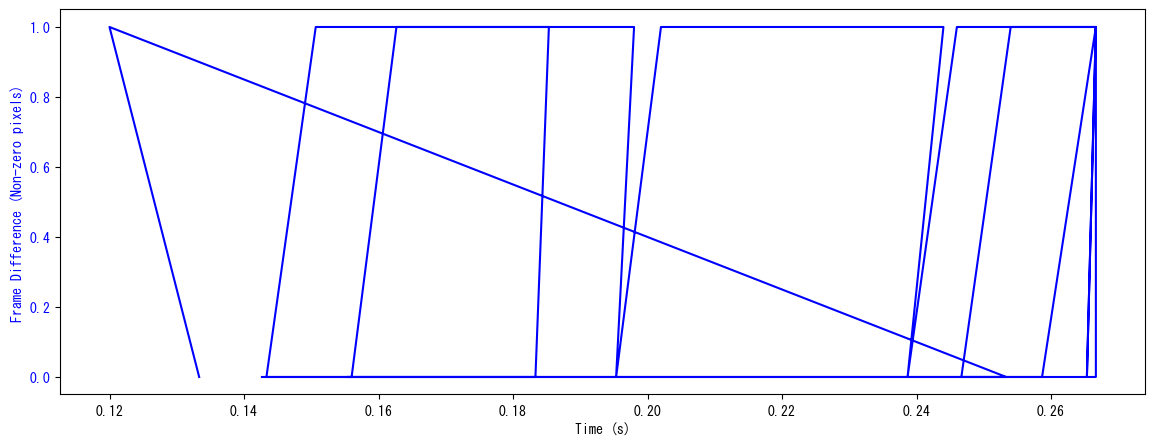

In [15]:
# -----------------------------------------------
# 実行
# -----------------------------------------------
if __name__ == "__main__":  
    # list_video_devices 関数を呼んで、PCに接続されているカメラを探す
    devices = list_video_devices()
    if not devices:
        # PCにカメラが接続されていない場合
        print("利用可能なカメラが見つかりませんでした")
    else:
        # PCにカメラが接続されている場合、launch_gui 関数を呼んで条件設定を行う
        selected_device, cam_thread_fps, capture_fps, capture_time, frame_interval, limit_frames = launch_gui(devices)
        if selected_device["idx"] is not None:
            # GUIでカメラが接続されていないる場合の処理
            # カメラスレッド設定FPS(取得値)
            cam = CameraCapture(selected_device["idx"], cam_thread_fps)
            print(f"選択されたデバイス番号: {selected_device["idx"]}")
            print(f"🎥 カメラスレッド設定FPS: {cam_thread_fps}")
            print(f"🎥 カメラスレッド設定FPS(取得値): {cam.fps_set:.2f}")
            print(f"🎥 カメラキャプチャ設定FPS: {capture_fps}")
        else:
            # GUIでカメラが接続されていない場合の処理
            print("カメラが選択されませんでした（GUIを閉じました）")

    # 「カメラが選ばれたときだけキャプチャを開始する」 という安全策
    if selected_device["idx"] is not None: 
        # start_capture_and_detect_workerを実行 ---
        frame_count, output_folder, actual_fps, stutter_files = start_capture_and_detect_worker(
            device_number=selected_device["idx"],
            target_width=640,
            target_height=480,
            display_fps=10,
            capture_fps=capture_fps,
            cam_thread_fps=cam_thread_fps,
            min_time_diff=0.1,
            max_temp_frames=18000,
            stop_no_diff_sec=300,
            k=2.0
        )

        # plot_stutter_csv関数を呼んでCSVログからグラフ化（フレーム画像を読み込む必要なし）
        plot_stutter_csv(output_folder, capture_fps)

        # --- システム情報取得 ---
        os_info = platform.platform()
        cpu_info = platform.processor()
        memory = psutil.virtual_memory()
        mem_total_gb = memory.total / (1024 ** 3)  # GB単位

        # GPU情報（複数ある場合は1台目を使用）
        gpus = GPUtil.getGPUs()
        gpu_info = gpus[0].name if gpus else "No GPU"

        # テキスト保存
        txt_path = os.path.join(save_folder, "fps_summary.txt")
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(f"🎥 カメラスレッド設定FPS: {cam_thread_fps:.2f}\n")
            f.write(f"🎥 カメラスレッド設定FPS（取得値）: {cam.fps_set:.2f}\n")
            f.write(f"⏱ カメラキャプチャ設定FPS: {capture_fps:.2f}\n")
            f.write("\n--- システム情報 ---\n")
            f.write(f"OS: {os_info}\n")
            f.write(f"CPU: {cpu_info}\n")
            f.write(f"メモリ合計: {mem_total_gb:.1f} GB\n")
            f.write(f"GPU: {gpu_info}\n")

        print(f"📁 保存フォルダ: {save_folder}")
        print(f"✅ CSV保存完了 : {csv_path}")
        print(f"✅ FPSサマリー保存完了: {txt_path}")
